In [1]:
#import necessary libraries for regression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('bmh')

from statsmodels.formula.api import ols
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats
from sklearn.model_selection import train_test_split

import pylab
from modelCustomFunctions import create_ols, check_resid_distribution, check_features_vif, get_low_pval_features

import uszipcode


In [2]:
df = pd.read_csv('Cleaned_Data_w_Outliers', index_col=0)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,1800,7503,0


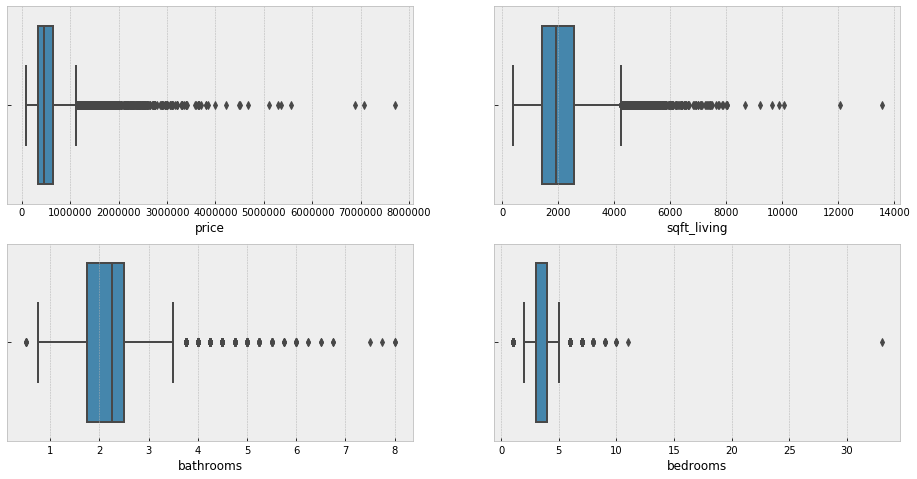

In [3]:
#Looking for Outliers
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.boxplot(x=df['price'])
plt.subplot(222)
sns.boxplot(x=df['sqft_living'])
plt.subplot(223)
sns.boxplot(x=df['bathrooms'])
plt.subplot(224)
sns.boxplot(x=df['bedrooms'])


In [4]:
#Remove outliers
df = df[df["price"] < 700000]
df = df[df["bedrooms"] < 13]
df = df[df["sqft_living"] < 11000]

In [5]:
df.shape

(17024, 18)

In [6]:
#Also, drop the yr_renoavted column since we have a new feature called 'renovated'
df = df.drop(columns = 'yr_renovated')

In [7]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,renovated
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,98125,1690,7639,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,98136,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,1800,7503,0


In [8]:
df.nunique() #looking at unique values in each column

price            2689
bedrooms           11
bathrooms          22
sqft_living       781
sqft_lot         8021
floors              6
waterfront          2
view                5
condition           5
grade               9
sqft_above        730
sqft_basement     236
yr_built          116
zipcode            69
sqft_living15     616
sqft_lot15       7106
renovated           3
dtype: int64

### Assumptions Check: Linearity and Multicolinearity

In [9]:
target = "price"
features = list(df.columns)
features.remove(target)

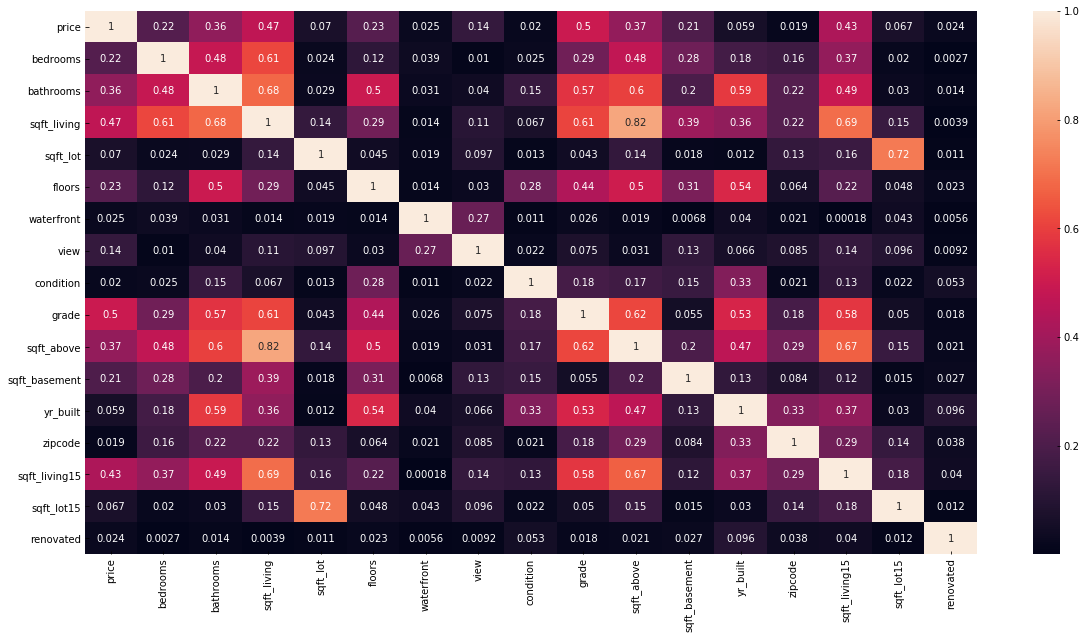

In [10]:
#explore features with high correlation 
corr = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [11]:
#Check Multicolinearity

check_features_vif(df, target)

,VIF Factor,features
0,26.3,bedrooms
1,27.7,bathrooms
2,875.4,sqft_living
3,2.4,sqft_lot
4,16.5,floors
5,1.1,waterfront
6,1.2,view
7,34.2,condition
8,155.7,grade
9,665.1,sqft_above


['sqft_living',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'zipcode',
 'sqft_living15']

In [12]:
df = df.drop(columns = ['yr_built','sqft_above','sqft_basement','sqft_living15', 'sqft_lot15', 'grade'])

In [13]:
check_features_vif(df, target)

,VIF Factor,features
0,25.6,bedrooms
1,22.6,bathrooms
2,21.3,sqft_living
3,1.2,sqft_lot
4,11.9,floors
5,1.1,waterfront
6,1.2,view
7,32.0,condition
8,58.1,zipcode
9,1.0,renovated


['condition', 'zipcode']

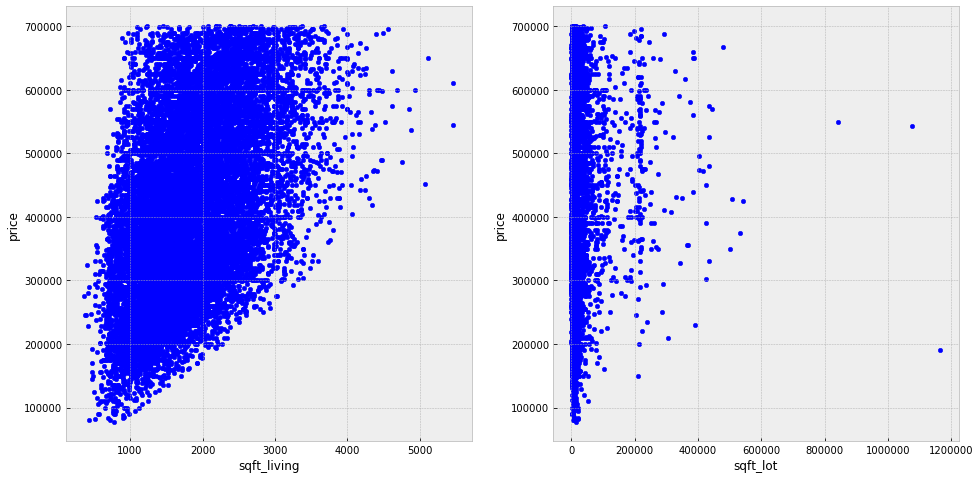

In [14]:
fig, axs = plt.subplots(1, 2)
df.plot(kind='scatter', x='sqft_living', y='price', ax=axs[0], figsize=(16, 8))
df.plot(kind='scatter', x='sqft_lot', y='price', ax=axs[1])


# Custom Functions to Test Assumptions

In [15]:
def check_homoskedasticity(model, df, target : "", features):
    
    """Inputs: 
    model: an sm.OLS model  
    df: a data frame
    target : a string 
    features: the features of the model 
    
    Retruns: 
    True if there's probable homoskedasticity
    False if there's probable skedasticity 
    Prints out P-value and F-statistic
    ------------------------
    Uses the Breusch–Pagan test. If p-value is below 0.05, then 
    the null hypothesis of homoskedasticity is rejected and 
    heteroskedasticity is assumed.
    """ 
    
    #Plot scatter plot
    y_hat = df[target] - model.predict(df[features])
            
    plt.scatter(model.predict(df[features]), y_hat, alpha = 0.2)
    plt.plot(model.predict(df[features]), [0 for i in range(len(df))])
    plt.show()

    #run Pegan test
    _, pval, _, f_pval = diag.het_breuschpagan(model.resid, model.model.exog)
    
    print('-'*50)
    print('The P-value is: {:.2}'.format(pval))
    print('The F-statistic is {:.2}'.format(f_pval))
    print('-'*50)
    
    if pval >= 0.05:
    
        print("The p-value is above 0.05, thus we fail to reject the null hypothesis of homoskedasticity")
        return True

    return False

In [16]:
def check_residuals(df, target, features, model):
    
    y_observed = df[target]
    y_hat = model.predict(df[features])
    residuals = model.resid
    # Plot scatter for Observed values vs predicted values
    sns.scatterplot(y_observed, y_hat)
    plt.title('Predictions')
    plt.xlabel('y_observed')
    plt.ylabel('y_hat')
    plt.show()
    
    # Check homoskedasticity with a scatter plot
    x_axis = np.linspace(0,1,len(residuals))
    sns.scatterplot(x_axis, residuals)
    plt.hlines(y=0, xmin=0, xmax=1, color='red')
    plt.title('Check for Homoskedasticity')
    plt.ylabel('Residuals')
    plt.show()
    
    # Plot the distribution of residuals
    sns.histplot(residuals)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    
    # Check Residuals distribution wiht QQPlot
    # Get exact Mean of Residuals
    check_resid_distribution(model)
    
    #Print RMSE
    print(f"Mean residuals: $ {round(residuals.abs().mean(),2)}")

## Baseline Model

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
baseline = create_ols(df, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     625.4
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:16:10   Log-Likelihood:            -2.2300e+05
No. Observations:               17024   AIC:                         4.460e+05
Df Residuals:                   17013   BIC:                         4.461e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.241e+07   1.73e+06    -18.699      

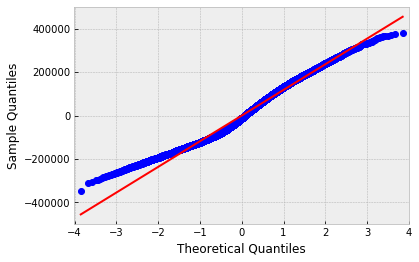

The mean of the residuals is: 3.9e-07. The closer to 0, the better.


In [19]:
check_resid_distribution(baseline)

In [20]:
features = list(df.columns)
features.remove(target)

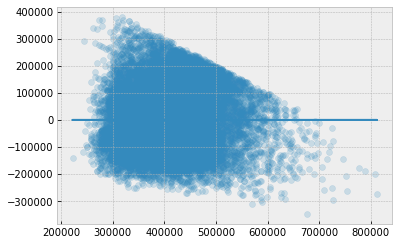

--------------------------------------------------
The P-value is: 1.9e-22
The F-statistic is 1.6e-22
--------------------------------------------------


False

In [21]:
check_homoskedasticity(baseline, df ,target, features)

### Model 2 

To improve on our baseline, we'll start by engineering some additional features that will quantify the value of zip codes a bit better.

##### Feature engineering

In [22]:
#Average (median) Household Income per zip code
search = uszipcode.SearchEngine()
def zip_income(x):
    income = search.by_zipcode(x).median_household_income
    return income if income else x 

df['avg_income_zip'] = df.zipcode.apply(zip_income)

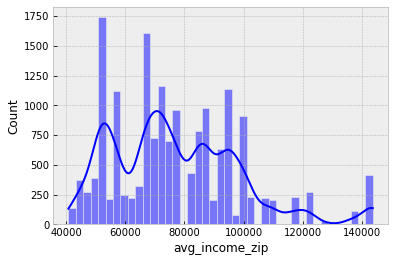

In [23]:
#Preview distribution for the new feature
sns.histplot(df.avg_income_zip, kde=True)

In [24]:
#Population density for zip codes
def population_density(x):
    density = search.by_zipcode(x).population_density
    return density if density else x

df['zip_population_density'] = df.zipcode.apply(population_density)

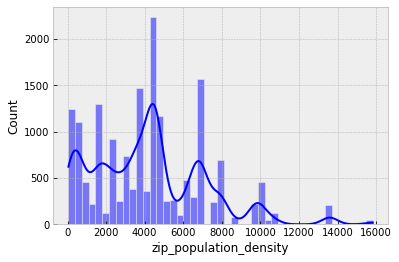

In [25]:
#Preview distribution for the new feature
sns.histplot(df.zip_population_density, kde=True)

In [ ]:
#Dropping zip code as we've engineered more useful features that represent the value of a location
df = df.drop(columns='zipcode')
df.head(3)

#### Creating the second model

In [26]:
model2 = create_ols(df, target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2190.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:17:07   Log-Likelihood:            -2.1771e+05
No. Observations:               17024   AIC:                         4.354e+05
Df Residuals:                   17011   BIC:                         4.355e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.49

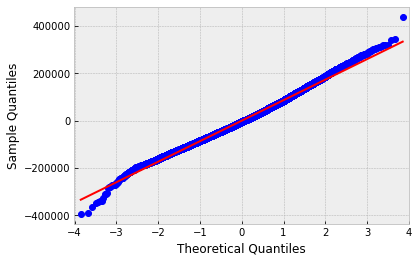

The mean of the residuals is: 2.6e-07. The closer to 0, the better.


In [27]:
check_resid_distribution(model2)

In [28]:
features2 = list(df.columns)
features2.remove(target)

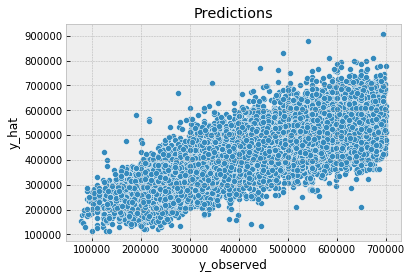

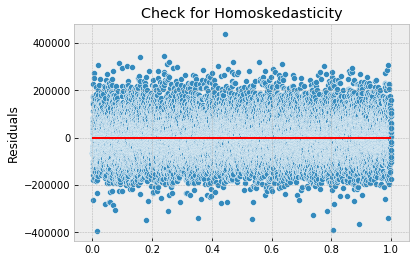

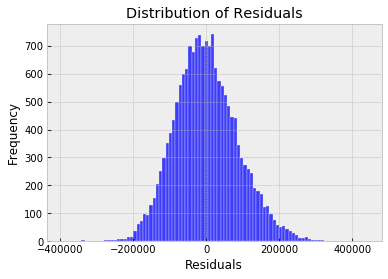

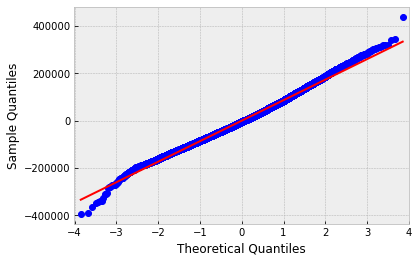

The mean of the residuals is: 2.6e-07. The closer to 0, the better.
Mean residuals: $ 68418.36


In [29]:
check_residuals(df, target, features2, model2 )

### Model 3

In [30]:
#Let's take a look at our features once again
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'zipcode',
 'renovated']

Continuous variables: 'sqft_living', 'sqft_lot', 'price'

(0, 10000)

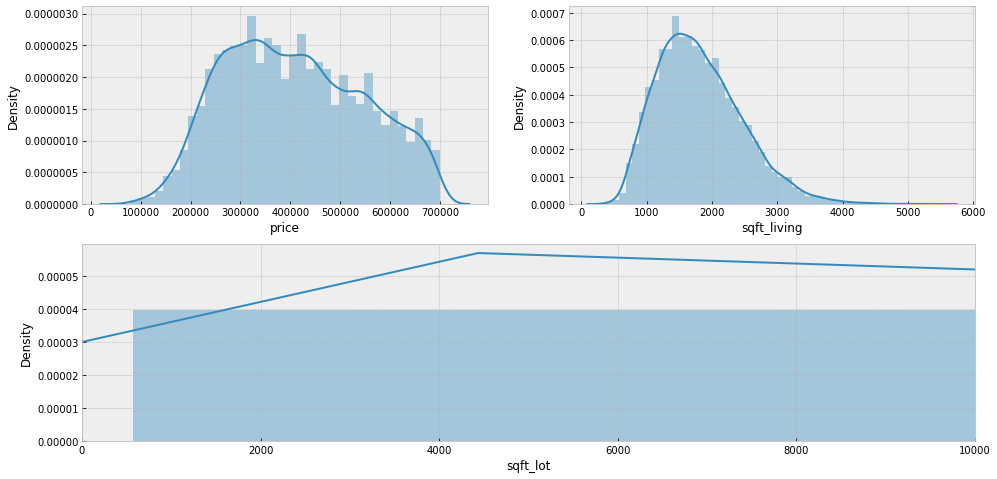

In [31]:
#Exploring distributions of continuous variables
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(df.price, label='Prices')
plt.subplot(222)
sns.distplot(df.sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(df.sqft_lot, label='Sqft Lot')
plt.xlim(0, 10000)

In [32]:
# Convert to logs
price = np.log(df.price)
sqft_living = np.log(df.sqft_living)
sqft_lot = np.log(df.sqft_lot)

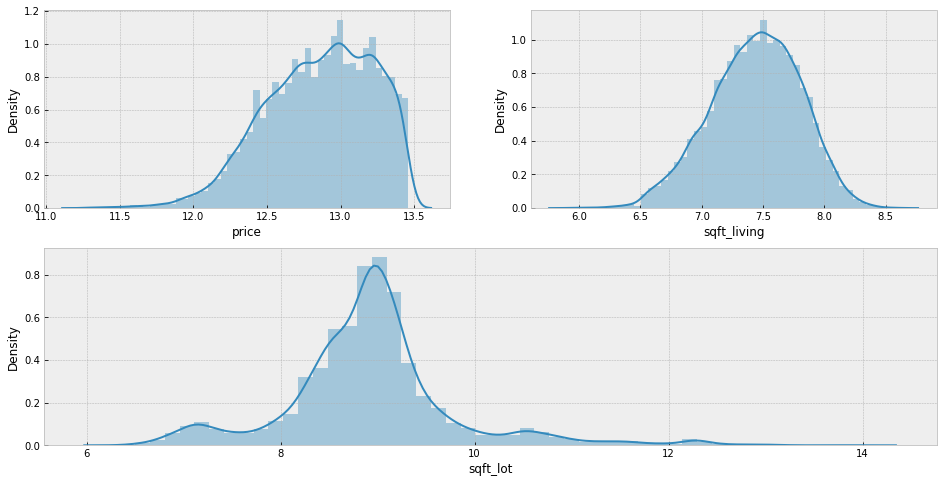

In [33]:
#Comparing the distributions
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(price, label='Prices')
plt.subplot(222)
sns.distplot(sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(sqft_lot, label='Sqft Lot')

In [34]:
#Next, do min-max transformation:

#df['price'] = ( price - min(price) ) / ( max(price) - min(price) )
#df['sqft_living'] = ( sqft_living - min(sqft_living) ) / ( max(sqft_living) - min(sqft_living) )
#df['sqft_lot'] = ( sqft_lot - min(sqft_lot) ) / ( max(sqft_lot) - min(sqft_lot) )


df['sqft_living'] = sqft_living
df['sqft_lot'] =sqft_lot

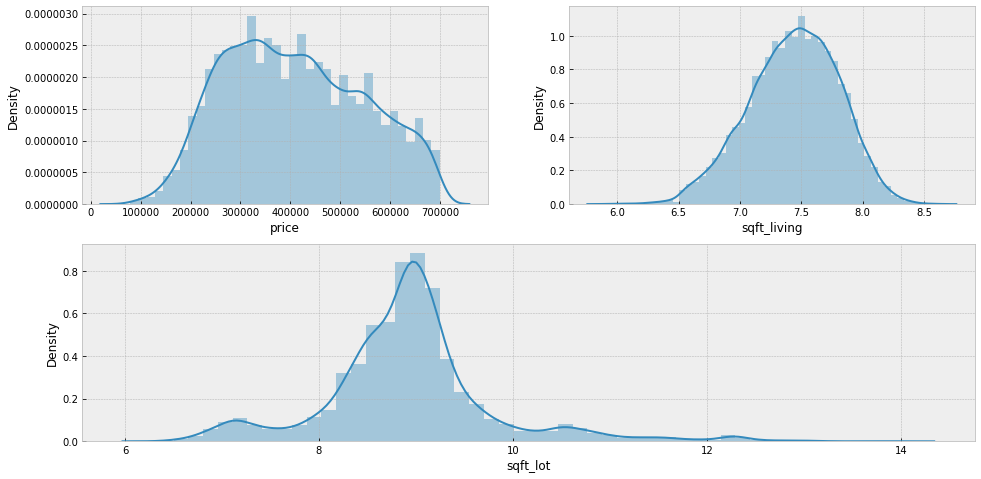

In [35]:
#Preview new distributions after min-max scaling
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.distplot(df.price, label='Prices')
plt.subplot(222)
sns.distplot(df.sqft_living, label='Sqft Living')
plt.subplot(212)
sns.distplot(df.sqft_lot, label='Sqft Lot')

In [36]:
model3 = create_ols(df,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     2209.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:18:36   Log-Likelihood:            -2.1767e+05
No. Observations:               17024   AIC:                         4.354e+05
Df Residuals:                   17011   BIC:                         4.355e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.89

In [37]:
features3 = list(df.columns)
features3.remove(target)

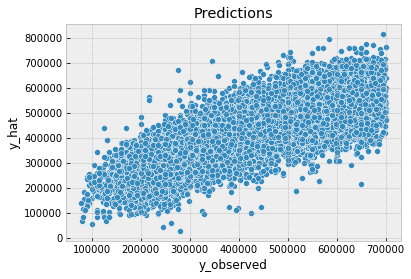

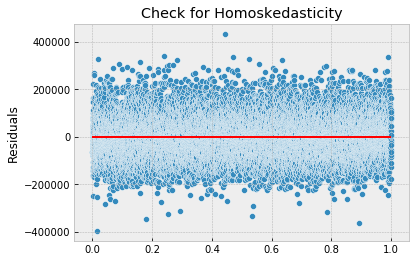

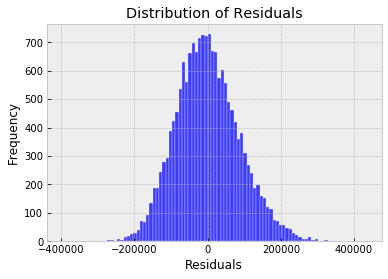

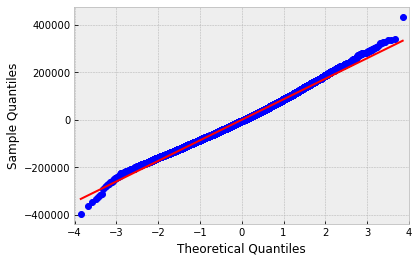

The mean of the residuals is: 1.1e-06. The closer to 0, the better.
Mean residuals: $ 68448.21


In [38]:
check_residuals(df, target, features3, model3 )

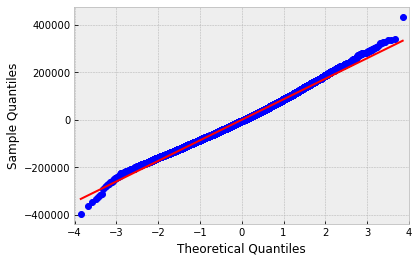

The mean of the residuals is: 1.1e-06. The closer to 0, the better.


In [39]:
check_resid_distribution(model3)

### Model 4

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17024 entries, 0 to 21596
Data columns (total 13 columns):
price                     17024 non-null float64
bedrooms                  17024 non-null int64
bathrooms                 17024 non-null float64
sqft_living               17024 non-null float64
sqft_lot                  17024 non-null float64
floors                    17024 non-null float64
waterfront                17024 non-null float64
view                      17024 non-null float64
condition                 17024 non-null int64
zipcode                   17024 non-null int64
renovated                 17024 non-null int64
avg_income_zip            17024 non-null int64
zip_population_density    17024 non-null float64
dtypes: float64(8), int64(5)
memory usage: 1.8 MB


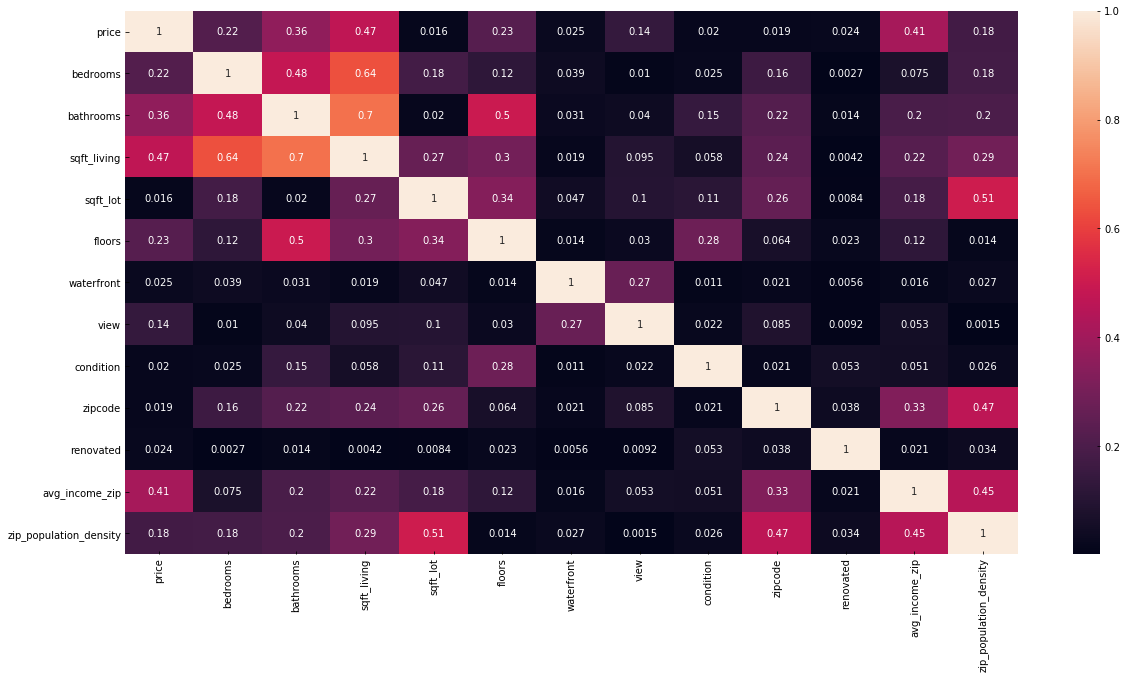

In [41]:
corr2 = df.corr().abs()
plt.figure(figsize=(20,10))
ax = sns.heatmap(corr2, annot=True) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [42]:
#Drop renovated, wterfront and sqft_lot as they have low correlation with our target variable
df6 = df.drop(columns=['bedrooms','bathrooms', 'renovated'])

In [43]:
def city_name(x):
    city = search.by_zipcode(x).city
    return city if city else x 

df6['city'] = df6.zipcode.apply(city_name)

In [44]:
df6.city.value_counts()

Seattle          7189
Renton           1487
Kent             1184
Auburn            896
Federal Way       762
Kirkland          707
Bellevue          615
Redmond           593
Maple Valley      569
Issaquah          552
Sammamish         415
Woodinville       333
Kenmore           270
Snoqualmie        269
Enumclaw          228
North Bend        200
Duvall            186
Bothell           182
Carnation         109
Vashon            102
Black Diamond      88
Fall City          58
Mercer Island      30
Name: city, dtype: int64

In [47]:
df6.city = df6.city.astype('category')
city = pd.get_dummies(df6.city, prefix='city')
df_new = pd.concat([df6, city], axis=1)

In [50]:
df_new = df_new.drop(columns = ['zipcode','city','city_Seattle'])

In [ ]:
#df.view = df.view.astype('category')
#df.condition = df.condition.astype('category')
#df.floors = df.floors.astype('category')

In [ ]:
#Making Dummies
#waterfront = pd.get_dummies(df.waterfront, prefix='waterfront', drop_first=True)
#view = pd.get_dummies(df.view, prefix='view', drop_first=True)
#condition = pd.get_dummies(df.condition, prefix='condition', drop_first=True)
#grade = pd.get_dummies(df.grade, prefix='grade', drop_first=True)
#bedrooms = pd.get_dummies(df.bedrooms, prefix='bedrooms', drop_first=True)
#floors = pd.get_dummies(df.floors, prefix='floors', drop_first=True)
#bathrooms = pd.get_dummies(df.bathrooms, prefix='bathrooms', drop_first=True)

In [ ]:
#df4 = df4.join([condition])
#df4.drop(['condition'], axis=1, inplace=True)

In [53]:
subs = [(' ','_')]
def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df_new.columns = [col_formatting(col) for col in df_new.columns]

In [54]:
model4 = create_ols(df_new,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1268.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:22:57   Log-Likelihood:            -2.1566e+05
No. Observations:               17024   AIC:                         4.314e+05
Df Residuals:                   16993   BIC:                         4.316e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.56

In [56]:
df_new2 = df_new.drop(columns=['city_Black_Diamond','city_Fall_City'])

In [57]:
model5 = create_ols(df_new2,target)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     1358.
Date:                Tue, 24 Nov 2020   Prob (F-statistic):               0.00
Time:                        00:24:27   Log-Likelihood:            -2.1566e+05
No. Observations:               17024   AIC:                         4.314e+05
Df Residuals:                   16995   BIC:                         4.316e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1.56

In [58]:
features5 = list(df_new2.columns)
features5.remove(target)

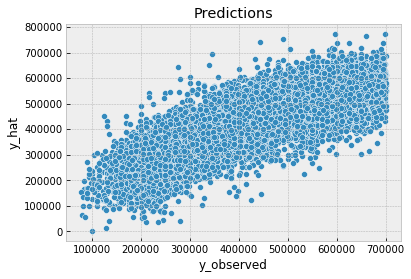

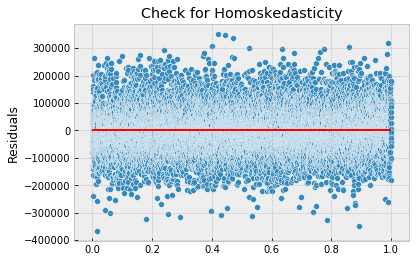

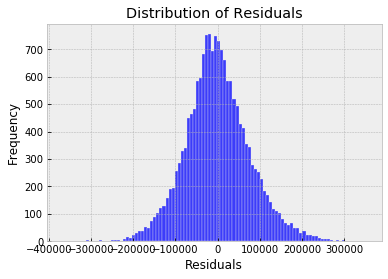

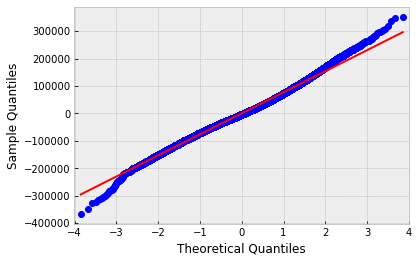

The mean of the residuals is: -2.5e-06. The closer to 0, the better.
Mean residuals: $ 59091.47


In [59]:
check_residuals(df_new2, target, features5, model5)